# Core

> In this file we define the basic building blocks before implementing the whole project.

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

import fastcore.all as fc

from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F

We automatically select the device on which to run our experiments.

In [ ]:
#| export
# setting a default device 
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

We also set a basic set of hyper parameters. These hypermeters can later be replaced by other values.

In [ ]:
#| export
CHANNEL_N = 16
TARGET_PADDING = 16
TARGET_SIZE = 40

POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

# Loading the target image

In [ ]:
path = '../images/emoji_u1f98e.png'

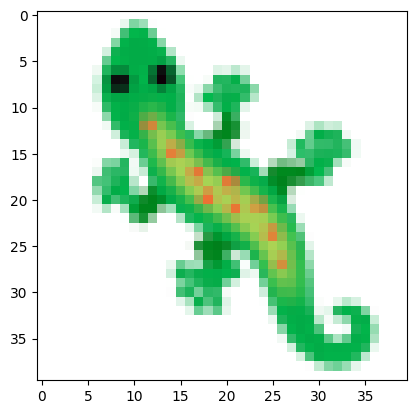

In [ ]:
# load image using PILL
img = Image.open(path).resize((TARGET_SIZE, TARGET_SIZE))

# Convert the image to numpy array 
img = np.array(img)
img = img.astype(np.float32) / 255.0

# Display the image
plt.imshow(img)
plt.show()

In [ ]:
#| export 
def load_image(path):
    "Load the image specified by `path` and return a `torch.tensor` version of the image with shape B, C, H, W, already on the default device"
    
    img = Image.open(path).resize((TARGET_SIZE, TARGET_SIZE))
    # Convert the image to numpy array 
    img = np.array(img)
    img = img.astype(np.float32) / 255.0

    # Display the image
    plt.imshow(img)
    plt.show()
    
    img_tensor = torch.tensor(img).permute(2, 0, 1)[None].to(def_device)
    
    return img_tensor

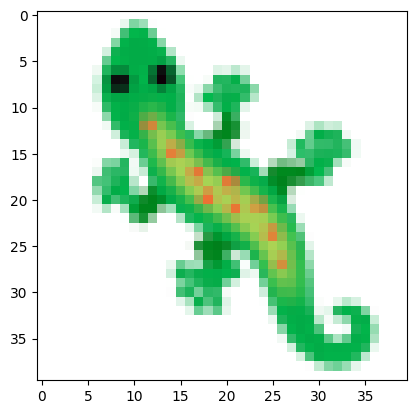

In [ ]:
img_tensor = load_image(path)

# Implementing the filters

In [ ]:
#| export 
filters = torch.stack([
    torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),      # Identity filter 
    torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),   # Vertical sobel filter
    torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T  # Horizontal sobel filter
]).to(def_device)

In [ ]:
filters

tensor([[[ 0.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0.,  0.,  0.]],

        [[-1.,  0.,  1.],
         [-2.,  0.,  2.],
         [-1.,  0.,  1.]],

        [[-1., -2., -1.],
         [ 0.,  0.,  0.],
         [ 1.,  2.,  1.]]], device='cuda:0')

We also need a function that will apply these filters per channel on an input image. 

In [ ]:
#| export 
def perchannel_conv(x, filters):
    b, c, h, w = x.shape
    y = x.reshape(b * c, 1, h, w)
    y = F.pad(y, (1, 1, 1, 1), mode='circular')
    y = F.conv2d(y, filters[:, None])
    return y.reshape(b, -1, h, w)

Let's test the results of applying the filters to the original image

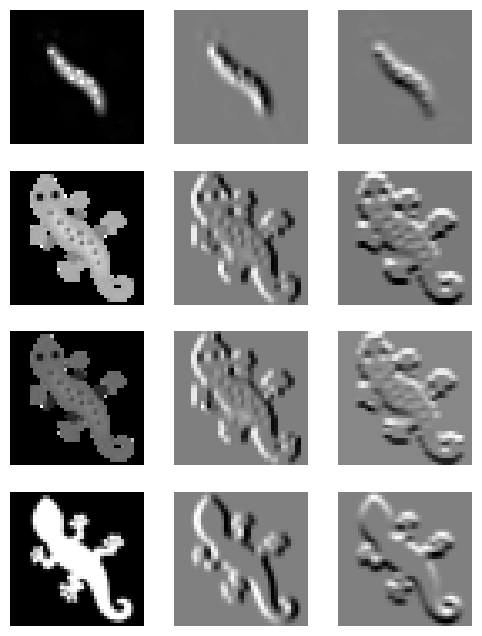

In [ ]:
filtered_images = perchannel_conv(img_tensor, filters)

# We apply 3 filter seperately on the 4 channels of the image
# resulting in a total of 12 images.
# To visualize them we will use a 4x3 grid (channelsxfilters)
plt.figure(figsize=(6,8))
for i in range(12):
    plt.subplot(4, 3, i+1)
    plt.imshow(filtered_images[0, i].detach().cpu(), cmap='gray')
    plt.axis('off')

# Create the CA model

First, we'll create a function to detect alive cells. A cell is considered alive if it has an alpha value greater than 0.1 or if any of its neighbors does.

In [ ]:
#| export
def alive(x, threshold=0.1):
    x = F.pad(x, (1, 1, 1, 1), mode='circular')
    return F.max_pool2d(x, 3, stride=1, padding=0) > threshold

In [ ]:
#| export
class CAModel(nn.Module):
    
    def __init__(self, channel_n, update_rate=0.5):
        super().__init__()
        
        self.channel_n = channel_n
        self.update_rate = update_rate
        
        self.brain = nn.Sequential(
            nn.Conv2d(channel_n * 3, 128, kernel_size=1), # pixel-wise mlp 
            nn.ReLU(),
            nn.Conv2d(128, self.channel_n, kernel_size=1, bias=False)
        )
        
        # this network is used to calculate the change of the features, so initially, we dont want to suggest any changes
        # thus we set the output weights to zero
        with torch.no_grad():
            self.brain[-1].weight.zero_()

    def step(self, x, update_rate=None):
        
        # -- Perception -- (apply the filters to the input)
        y = perchannel_conv(x, filters)
        
        # -- Update Rule -- (pass the input through the brain)
        y = self.brain(y)

        # -- Stochastic cell update --
        B, C, H, W = y.shape
        update_rate = update_rate or self.update_rate # if update_rate is not given, use the default value
        update_mask = (torch.rand(B, 1, H, W).to(def_device) + update_rate).floor() 
        x = x + y * update_mask # update only a fraction of the cells

        # -- Alive masking --
        alive_mask = alive(x[:, 3:4, :, :], threshold=0.1) # we use 3:4 to keep the dimension
        x = x * alive_mask

        return x

    def forward(self, x, steps=1, update_rate=None):
        for i in range(steps):
            x = self.step(x, update_rate=update_rate)
        return x

Testing the Model...

In [ ]:
# Instantiate the model
ca = CAModel(16).to(def_device)

# Create a dummy input
seed = torch.rand(1, 16, TARGET_SIZE, TARGET_SIZE).to(def_device)

# Activate the model
res = ca(seed)

res.shape

torch.Size([1, 16, 40, 40])

# Display Animation
Later in the experiment, we'll require a tool for displaying animations. This will be used for visualizing the life and the expansion of the cellular automaton.

In [ ]:
# create a dummy series of images
images = []
for i in range(20):
    images.append(np.random.rand(40, 40, 4))

In [ ]:
#| export 
def display_animation(images): # A list containing the frames of the animation. Each frame should be of shape [H, W, 4]
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    ims = [[plt.imshow(image, animated=True)] for image in images]
    # display animation in jupyter notebook
    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    # display HTML
    return HTML(ani.to_jshtml())    

In [ ]:
display_animation(images)

## Create animation from the CAModel
We'll also incorporate the capability for the model to generate an animation depicting the cellular automaton's evolution across multiple steps.

In [ ]:
#| export
@fc.patch
def grow_animation(self: CAModel, seed, steps, update_rate=None):
    x = seed.clone()
    images = [torch.clamp(x[0, :4].detach().cpu().permute(1, 2, 0), 0, 1)]
    for _ in range(steps):
        x = self.step(x, update_rate=update_rate)
        images.append(torch.clamp(x[0, :4].detach().cpu().permute(1, 2, 0), 0, 1))
    return images

In [ ]:
images = ca.grow_animation(seed, 20)

In [ ]:
display_animation(images)